In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, label_binarize
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix,classification_report
import itertools
from scipy import interp
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pickle
from sklearn.cross_validation import cross_val_score, StratifiedKFold, train_test_split
from sklearn.grid_search import GridSearchCV 
import patsy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as tkr
import sqlite3
from ipywidgets import *
from IPython.display import display
import string

plt.style.use('fivethirtyeight')


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/lukejarmbruster/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/lukejarmbruster/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
sqlite_db = '/Users/lukejarmbruster/Desktop/DSI-SF-4-larmbruster/projects/capstone/facebook_news.sqlite'
conn = sqlite3.connect(sqlite_db) 
c = conn.cursor()

In [4]:
fb_news_total=pd.read_sql('SELECT * FROM fbook_news', con=conn)

In [5]:
conn.close()

In [6]:
# convert object columns from unicode to string
def decoder(x):
    if not x:
        return ''
    else:
        x_ = ''.join([ch for ch in x if ch in string.printable])
        return str(x_.decode('ascii'))
object_types=fb_news_total.columns[fb_news_total.dtypes=='object']
for i in object_types:
    fb_news_total[i] = fb_news_total[i].map(decoder)

In [7]:
fb_news_total.status_published=pd.to_datetime(fb_news_total.status_published)

In [8]:
# study period from August 26, 2016 [including] to January 19, 2017 [including ](includes 73 
# before and after election day)

mask=((fb_news_total['status_published'] >= '2016-08-26') & (fb_news_total['status_published'] < '2017-01-20')) 
fb_news_total=fb_news_total.loc[mask]
fb_news_total['election_day']='same'
fb_news_total.ix[fb_news_total['status_published']<'2016-11-07','election_day']='before'
fb_news_total.ix[fb_news_total['status_published']>='2016-11-08','election_day']='after'
fb_news_total.reset_index(inplace=True, drop=True)

#fb_news_total.ix[fb_news_total['election_day']=='same','status_published'].sort_values()
del mask

In [9]:
# add time columns
fb_news_total['day_of_week']=fb_news_total.status_published.dt.weekday_name
fb_news_total['year']=fb_news_total.status_published.dt.year
fb_news_total['month']=fb_news_total.status_published.dt.month
fb_news_total['day']=fb_news_total.status_published.dt.day
fb_news_total['hour']=fb_news_total.status_published.dt.hour

In [10]:
# investigate repeats in status_id, status_message, link_name, status_link, permalink_url
# removed duplicate posts
mask=((fb_news_total.duplicated(['status_id'])) & (fb_news_total.duplicated(['status_message'])) & 
      (fb_news_total.duplicated(['link_name'])) & (fb_news_total.duplicated(['status_link'])) &
      (fb_news_total.duplicated(['permalink_url'])) & (fb_news_total.duplicated(['status_published']))
     & (fb_news_total.duplicated(['num_reactions'])))

print sum(mask)
print sum(~mask)

# remove the rows with that repeat six of the same columns elements as another row
fb_news_total=fb_news_total[~mask]
fb_news_total.reset_index(inplace=True, drop=True)
del mask

99
274618


In [11]:
fb_news_total['all_interactions']=fb_news_total['num_reactions']+fb_news_total['num_shares']+fb_news_total['num_comments']

In [11]:
# The above rows are not necessary if bootstrap pickle object is loaded instead

In [12]:
fb_news_total.columns

Index([u'p_key', u'status_id', u'status_message', u'link_name', u'status_type',
       u'status_link', u'permalink_url', u'status_published', u'num_reactions',
       u'num_comments', u'num_shares', u'num_likes', u'num_loves', u'num_wows',
       u'num_hahas', u'num_sads', u'num_angrys', u'type', u'fb_id',
       u'election_day', u'day_of_week', u'year', u'month', u'day', u'hour',
       u'all_interactions'],
      dtype='object')

In [ ]:
with open('/Users/lukejarmbruster/Desktop/DSI-SF-4-larmbruster/projects/capstone/small_sample_bootstrap_data.pkl', 'r') as f:
    small_sample = pickle.load(f)

In [13]:
small_sample.drop(labels=['p_key','status_id','status_message','link_name','status_link',
                          'permalink_url','status_published','num_reactions','fb_id',
                          'activist post', 'visit reality', 'shares support', 'newsletter read',
                          'unto','insists','behold','david books','chuck','debbie','checked',
                          'swipe','wheel','friends weekend','packing',
                          'packing','schwartz','sunday night','elect mike','stretch','lamont',
                          'bundle','rosie','bat','consciously','chronicles manila','behold','unto'],axis=1,inplace=True)

subset=small_sample[['type','day_of_week','status_type','hour','num_comments', 'num_shares', 'num_likes', 'num_loves', 
                       'num_wows', 'num_hahas', 'num_sads', 'num_angrys','all_interactions','election_day']]
small_sample.drop(labels=['type','day_of_week','status_type','hour','num_comments', 'num_shares', 'num_likes', 
                          'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys','all_interactions',
                         'election_day'], axis=1,inplace=True)

for i in ['num_comments','num_shares','num_likes','num_loves','num_wows','num_hahas','num_sads','num_angrys']:
    subset.loc[:,i]=(1.0*subset.loc[:,i])/subset.loc[:,'all_interactions']
    subset.loc[subset['all_interactions']==0,i]=0
#    subset.loc[:,i]=np.sqrt(subset.loc[:,i])
    
#site_types=[i for i in site_types if i not in ['satire']]

#subset=subset[subset['type']!='satire'].reset_index(drop=True)
y_subset=pd.Series([-999] * len(subset['type']))

site_types=list(subset['type'].unique())
for i,item in enumerate(site_types):
    y_subset[subset['type']==item]=i

print sum(y_subset==-999)
    
weekday_types=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

subset.loc[:,'num_week_day']=-999

for i,item in enumerate(weekday_types):
    subset.loc[subset['day_of_week']==item,'num_week_day']=i

subset = subset.drop(['type','day_of_week','all_interactions'], 1)
subset['type']=y_subset
print sum(subset['num_week_day']==-999)
print sum(subset['num_comments'].isnull())

f = 'type ~ '+' + '.join([c for c in subset.columns if not c == 'type'])+' -1'
y, X = patsy.dmatrices(f, data=subset, return_type='dataframe')
X=X.join(small_sample)
X.info()
#X.columns[X.dtypes=='object']
X=X.values
y = y.values.ravel()

ss = StandardScaler()

Xn = ss.fit_transform(X)

params = {
    'multi_class':['ovr'],
    'class_weight':[None],
    'C': np.linspace(0.0001, 10, 200),
    'penalty':['l1'],
}

mlr = LogisticRegression(max_iter=200, random_state=42,tol=0.001)

mlr_gs = GridSearchCV(mlr, params, cv=5, verbose=2)
mlr_gs.fit(Xn, y)

print mlr_gs.best_params_
best_mlr = mlr_gs.best_estimator_

NameError: name 'small_sample' is not defined

In [14]:
x_subset=fb_news_total[['type','day_of_week','status_type','hour','num_comments', 'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys','all_interactions']]

for i in ['num_comments','num_shares','num_likes','num_loves','num_wows','num_hahas','num_sads','num_angrys']:
    x_subset.loc[:,i]=(1.0*x_subset.loc[:,i])/x_subset.loc[:,'all_interactions']
    x_subset.loc[x_subset['all_interactions']==0,i]=0
#    x_subset.loc[:,i]=np.sqrt(x_subset.loc[:,i])
    
#site_types=[i for i in site_types if i not in ['satire']]

#x_subset=x_subset[x_subset['type']!='satire'].reset_index(drop=True)
y_subset=pd.Series([-999] * len(x_subset['type']))

site_types=list(fb_news_total['type'].unique())
for i,item in enumerate(site_types):
    y_subset[x_subset['type']==item]=i
    
print sum(y_subset==-999)
    
weekday_types=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

x_subset.loc[:,'num_week_day']=-999

for i,item in enumerate(weekday_types):
    x_subset.loc[x_subset['day_of_week']==item,'num_week_day']=i

x_subset = x_subset.drop(['type','day_of_week','all_interactions'], 1)
x_subset['type']=y_subset
print sum(x_subset['num_week_day']==-999)
print sum(x_subset['num_comments'].isnull())



/Users/lukejarmbruster/anaconda/envs/dsi/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0


/Users/lukejarmbruster/anaconda/envs/dsi/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


0
0


In [15]:
with open('/Users/lukejarmbruster/Desktop/DSI-SF-4-larmbruster/projects/capstone/nlp_text.pkl', 'r') as f:
    nlp_text = pickle.load(f)

In [16]:
nlp_text.drop(labels=['activist post', 'visit reality', 'shares support', 'newsletter read',
                      'insists','behold','david books','chuck','debbie','checked',
                      'swipe','wheel','friends weekend',
                      'packing','schwartz','sunday night','elect mike','stretch','lamont',
                      'bundle','rosie','bat','consciously','chronicles manila','unto'],axis=1,inplace=True)

In [17]:
f = 'type ~ '+' + '.join([c for c in x_subset.columns if not c == 'type'])+' -1'
y, X = patsy.dmatrices(f, data=x_subset, return_type='dataframe')
X=X.join(nlp_text)
coefs_columns=X.columns
X=X.values
y = y.values.ravel()

In [15]:
X.shape

(274618, 521)

In [ ]:
ss = StandardScaler()
Xn = ss.fit_transform(X)


In [20]:
rf = RandomForestClassifier()
rf.fit(Xn, y)
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), coefs_columns), 
             reverse=True)

Features sorted by their score:
[(0.1297, 'num_shares'), (0.1009, 'num_comments'), (0.0996, 'num_likes'), (0.0981, 'num_loves'), (0.0962, 'num_sads'), (0.0955, 'num_wows'), (0.0784, 'num_hahas'), (0.0752, 'hour'), (0.0732, 'num_angrys'), (0.0379, 'num_week_day'), (0.0153, 'status_type[video]'), (0.0117, 'status_type[photo]'), (0.0095, 'status_type[link]'), (0.0036, 'status_type[status]'), (0.0015, u'shouts'), (0.0013, u'neverhillary'), (0.0012, u'trey gowdy'), (0.0011, u'thug'), (0.001, u'thugs'), (0.001, u'mark dice'), (0.001, u'follow president'), (0.0009, u'follow american'), (0.0008, u'support trump'), (0.0008, u'stop cheering'), (0.0007, u'jihad'), (0.0006, u'god bless'), (0.0005, u'think trump'), (0.0005, u'sharks'), (0.0005, u'reality bites'), (0.0005, u'pres barack'), (0.0005, u'liberty movement'), (0.0005, u'kyle rearden'), (0.0005, u'follow deplorable'), (0.0005, u'bubba'), (0.0005, u'american needs'), (0.0004, u'world news'), (0.0004, u'trump like'), (0.0004, u'think obama')

In [23]:
features_selected=sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), coefs_columns), 
             reverse=True)
len(rf.feature_importances_)

521

In [24]:
temp=[]
for i in features_selected:
    if i[0]>0:
        temp.append(str(i[1]))
features_selected=temp

del temp

In [25]:
final_predictor_index=[]
for i in features_selected:
    final_predictor_index.append(coefs_columns.get_loc(i))
final_predictor_names=coefs_columns[final_predictor_index]

In [26]:
Xn=np.delete(Xn, final_predictor_index, axis=1)

In [65]:
# baseline
print "mainstream baseline: Count - ",(1.*sum(y_subset==0)), "Fraction - ",(1.*sum(y_subset==0))/len(y_subset)
print "fake baseline: Count - ",(1.*sum(y_subset==1)), "Fraction - ",(1.*sum(y_subset==1))/len(y_subset)
print "conspiracy baseline: Count - ",(1.*sum(y_subset==2)), "Fraction - ",(1.*sum(y_subset==2))/len(y_subset)
print "satire baseline: Count - ",(1.*sum(y_subset==3)), "Fraction - ",(1.*sum(y_subset==3))/len(y_subset)

mainstream baseline: Count -  87295.0 Fraction -  0.317877924972
fake baseline: Count -  113528.0 Fraction -  0.413403345738
conspiracy baseline: Count -  55843.0 Fraction -  0.203347923297
satire baseline: Count -  17952.0 Fraction -  0.0653708059923


In [ ]:
#ros = RandomOverSampler(random_state=42)

xtr, xte, ytr, yte = train_test_split(Xn, y, test_size=0.3,random_state=42)

cv_indices = StratifiedKFold(ytr, n_folds=5)

logreg = LogisticRegression(multi_class='ovr', max_iter=300, random_state=42,tol=0.001,C=1)

lr_scores = []

for train_inds, test_inds in cv_indices:
    
    xtr_subset, ytr_subset = xtr[train_inds, :], ytr[train_inds]
#    xtr_subset, ytr_subset = ros.fit_sample(xtr_subset, ytr_subset)
    xte_subset, yte_subset = xtr[test_inds, :], ytr[test_inds]
    
    logreg.fit(xtr_subset, ytr_subset)
    lr_scores.append(logreg.score(xte_subset, yte_subset))
    
print 'Logistic Regression:'
print lr_scores
print np.mean(lr_scores)

In [ ]:
# test on entire training set
logreg.fit(xtr,ytr)

# calculate score based on fit
holdout= logreg.score(xte, yte)
print holdoutr2

# predict 
pred=logreg.predict(xte)

In [68]:
# baseline of test set
mainstream_baseline=(1.*sum(yte==0))/len(yte)
fake_baseline=(1.*sum(yte==1))/len(yte)
conspiracy_baseline=(1.*sum(yte==2))/len(yte)
satire_baseline=(1.*sum(yte==3))/len(yte)

print "mainstream baseline: ", mainstream_baseline
print "fake baseline: ", fake_baseline
print "conspiracy baseline: ", conspiracy_baseline
print "satire baseline: ", satire_baseline

mainstream baseline:  0.316631466511
fake baseline:  0.414026655014
conspiracy baseline:  0.205289733693
satire baseline:  0.0640521447819
mean of categories 0.25


In [69]:
# prediction
print "mainstream prediction: ",(1.*sum(pred==0))/len(pred)
print "fake prediction: ",(1.*sum(pred==1))/len(pred)
print "conspiracy prediction: ",(1.*sum(pred==2))/len(pred)
print "satire prediction: ",(1.*sum(pred==3))/len(pred)

mainstream prediction:  0.365802442163
fake prediction:  0.590075983784
conspiracy prediction:  0.0245065909256
satire prediction:  0.0196149831282


In [70]:
# class report
print(classification_report_imbalanced(yte, pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.61      0.71      0.79      0.66      0.72      0.51     26086
        1.0       0.54      0.78      0.54      0.64      0.65      0.41     34110
        2.0       0.73      0.09      0.99      0.15      0.77      0.58     16913
        3.0       0.53      0.16      0.99      0.25      0.71      0.48      5277

avg / total       0.60      0.57      0.74      0.52      0.70      0.48     82386

4


,status_type[event],status_type[link],status_type[note],status_type[photo],status_type[status],status_type[video],hour,num_comments,num_shares,num_likes,...,behold,bitcoin,free press,world tour,tour tickets,david books,unto,sharks,insists,balls
0,-0.034795,0.052840,-0.025282,-0.463162,-0.125972,0.469459,-0.014239,0.856461,0.160343,1.570375,...,0.005499,-0.007593,-0.024514,0.048941,-0.034967,-0.042296,-0.005264,-0.120439,-0.000009,-0.007290
1,-0.030006,0.051874,-0.023860,0.283612,-0.134113,-0.344755,0.056593,0.017398,0.038429,-0.354206,...,-0.005621,-0.015606,-0.007708,-0.054064,-0.046170,-0.051706,-0.028381,0.150616,-0.024143,-0.001720
2,0.019384,0.052028,0.007659,0.046041,0.184725,-0.176501,-0.017238,-0.411717,0.161209,-0.263377,...,-0.004453,0.026486,0.024110,-0.022382,0.096362,0.066985,0.025125,-0.155922,-0.020322,-0.008767
3,0.048232,0.060300,0.008835,-0.149933,-0.015928,0.079406,-0.125946,-0.202278,0.176173,0.677915,...,0.007978,-0.070273,-0.010750,-0.037851,-0.030515,-0.025777,-0.042052,-0.103314,0.035748,0.019705


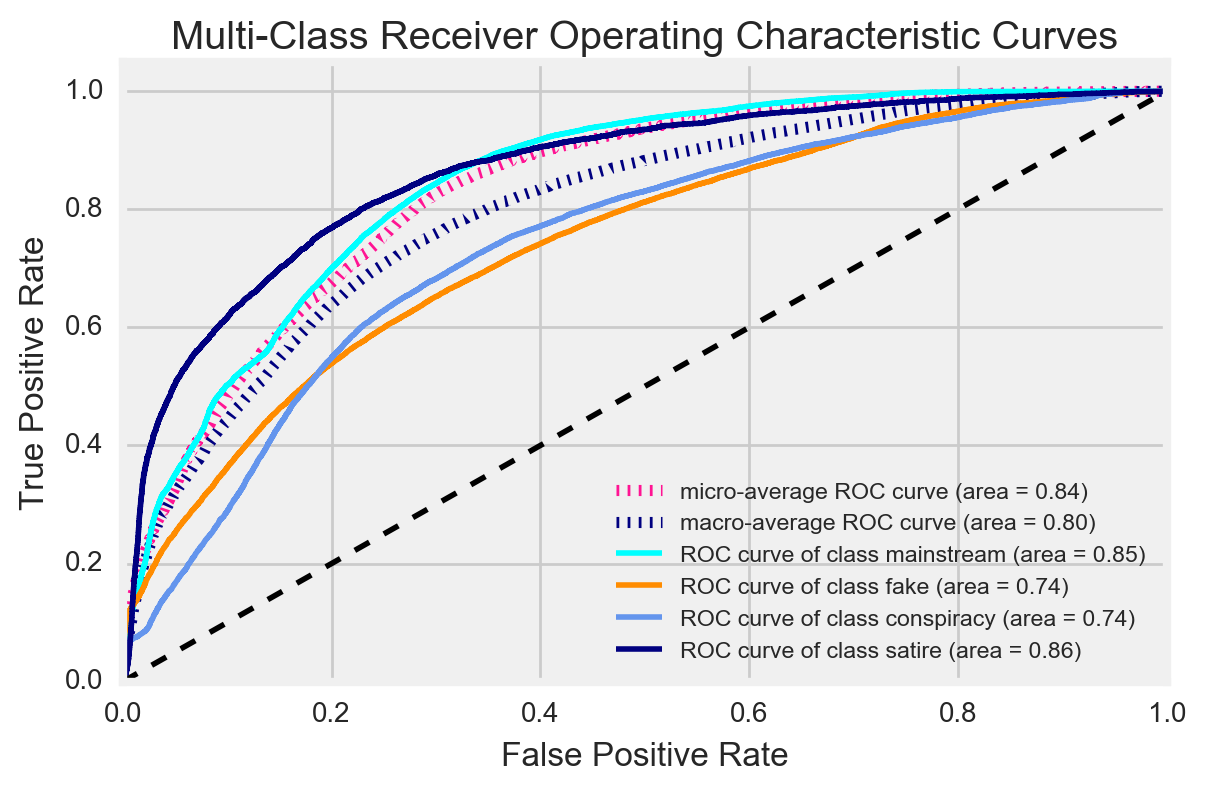

In [83]:
bin_yte= label_binarize(yte, classes=[0, 1, 2, 3])
n_classes = bin_yte.shape[1]

# Get out the predicted probabilities and scores for the X observation matrix
#y_prob = logreg.predict_proba(xte)
y_score = logreg.fit(xtr, ytr).decision_function(xte)

# roc_curve returns the false positive rate and true positive rates as the threshold changes
# takes in the y and the predicted probabilities of the positive class from your model.
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(bin_yte[:, i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(bin_yte.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue','navy']
class_names=['mainstream','fake','conspiracy','satire']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class Receiver Operating Characteristic Curves')
plt.legend(loc="lower right",fontsize='small')
plt.show()

Confusion matrix, without normalization
[[18463  7379   114   130]
 [ 6806 26442   395   467]
 [ 2919 12364  1466   164]
 [ 1949  2429    44   855]]


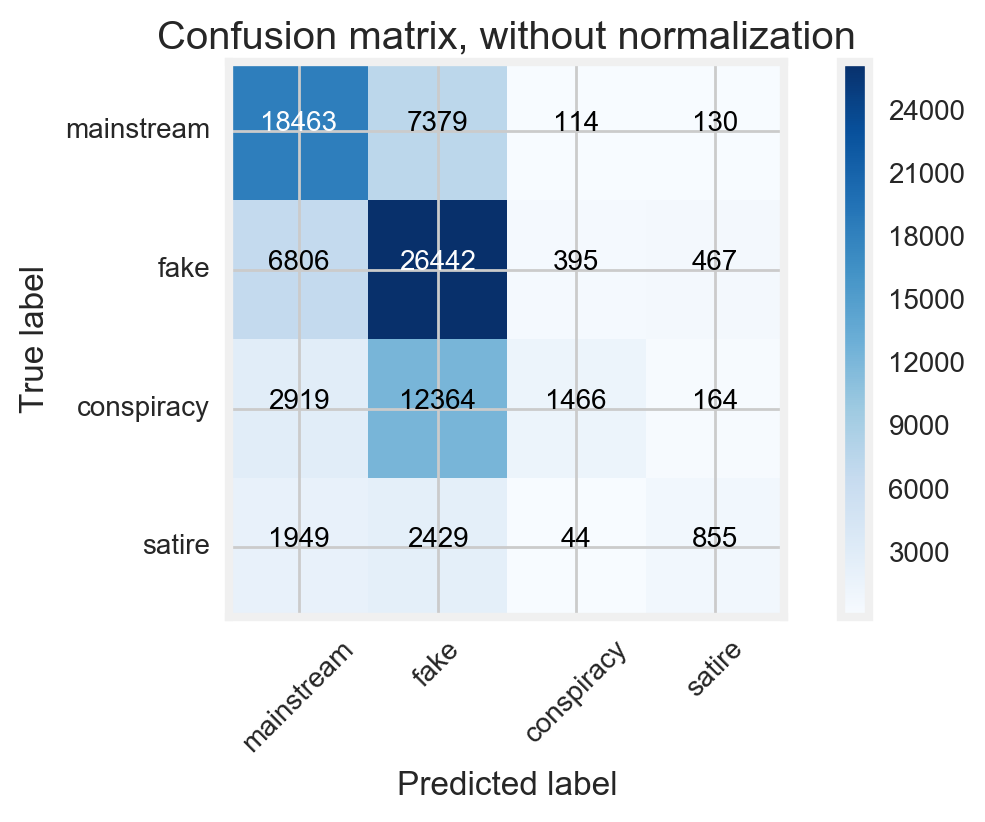

In [77]:
# plot code from scikitlearn
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=['mainstream','fake','conspiracy','satire']
cnf_matrix = confusion_matrix(yte, pred)
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# test on entire dataset
logreg.fit(Xn,y)

In [71]:
# building coefs
coefs = pd.DataFrame(logreg.coef_, columns=coefs_columns)
coefs.index = list(fb_news_total['type'].unique())
log_reg_coefs=coefs.transpose().sort_values(by=0, ascending=False).reset_index()

In [72]:
log_reg_coefs.rename(index=str, columns={"index":"predictors",0: "mainstream", 1: "fake", 2:"conspiracy",3:"satire"},inplace=True)
log_reg_coefs=pd.melt(log_reg_coefs, id_vars=['predictors'], value_vars=['mainstream', 'fake','conspiracy','satire'])

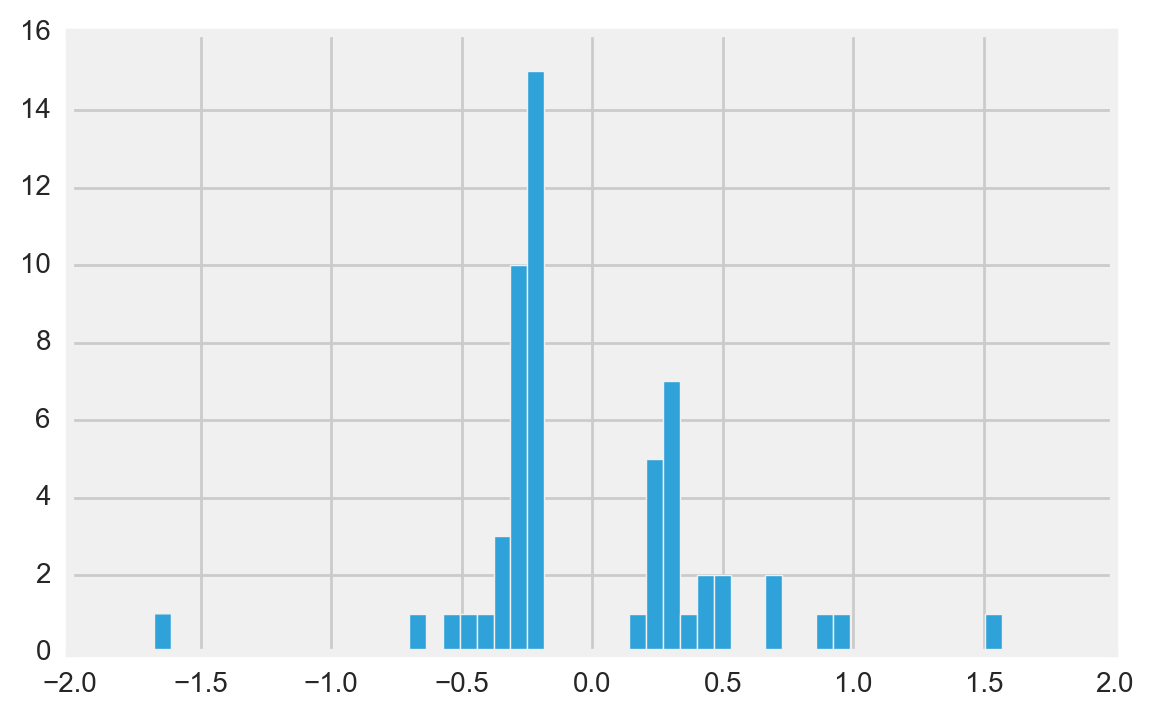

In [74]:
log_reg_coefs.ix[log_reg_coefs['value'].abs()>0.2,'value'].hist(bins=50)

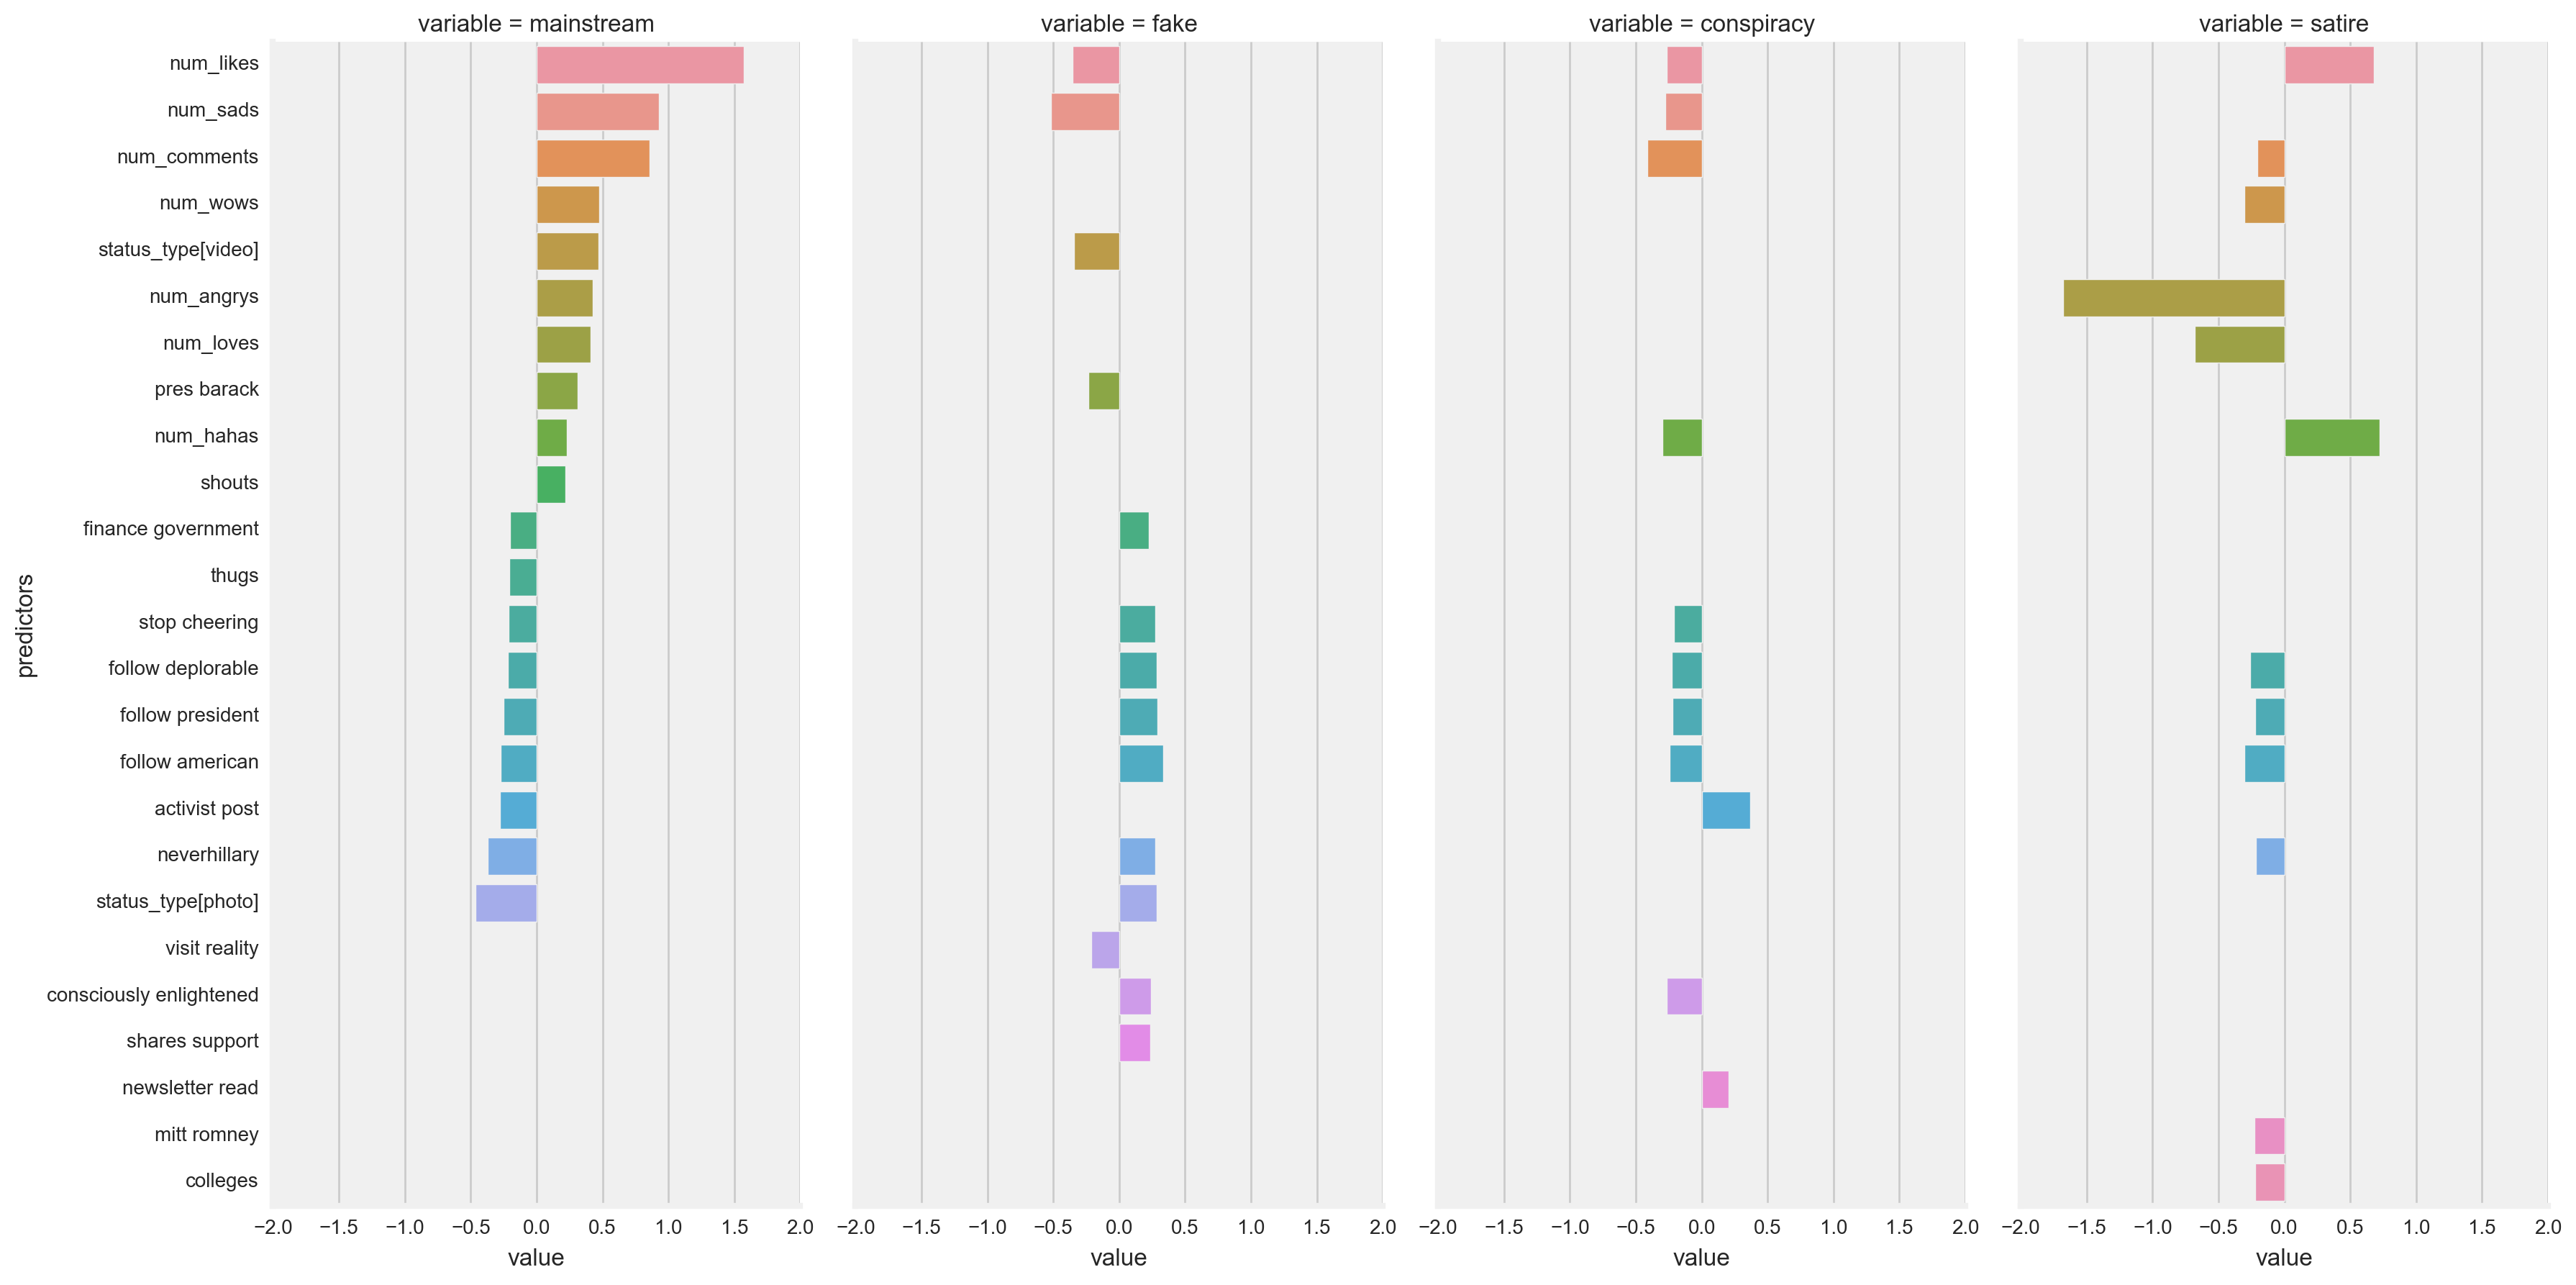

In [75]:
sns.factorplot(x='value', y='predictors', data=log_reg_coefs[log_reg_coefs['value'].abs()>0.2], col="variable",kind='bar',size=9, aspect=.5);